In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

In [6]:
run_sensitivity_with_simulator = False
m4_evaluate = False


We consider missiles with only 1 stage

In [7]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [8]:
from sklearn.metrics import mean_squared_error
import math

# TODO: improve considering also the variance 
# (i.e. penalise less if mean prediction is not accurate, but still within 2 std dev?)
def compute_rmse(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
 
    return RMSE

def evaluate_prediction(y_actual, y_predicted):
    return compute_rmse(y_actual, y_predicted)
    
    

## Sensitivity Analysis

In [9]:
rescale_0_1 = True


m4_param_1 = 'fuelmass'
m4_param_2 = 'Isp0'
m4_param_3 = 'drymass'
m4_param_4 = 'thrust0'
# m4_param_5 = 'payload'
# m4_param_6 = 'missilediam'
# I am not sure 'estrange' and 'rvdiam' can be changed freely

m4_domain_param_1 = basic_param_spaces[m4_param_1] # [500, 6000] # [5000,15000]
m4_domain_param_2 = basic_param_spaces[m4_param_2] # [200, 300] # [224, 228]
m4_domain_param_3 = basic_param_spaces[m4_param_3] 
m4_domain_param_4 = basic_param_spaces[m4_param_4] 
# m4_domain_param_5 = basic_param_spaces[m4_param_5] 
# m4_domain_param_6 = basic_param_spaces[m4_param_6] 

if rescale_0_1:
    m4_domain_param_1 = [0,1]
    m4_domain_param_2 = [0,1]
    m4_domain_param_3 = [0,1]
    m4_domain_param_4 = [0,1]
#     m4_domain_param_5 = [0,1]
#     m4_domain_param_6 = [0,1]
    


m4_space = ParameterSpace(
          [ContinuousParameter(m4_param_1, *m4_domain_param_1), 
           ContinuousParameter(m4_param_2, *m4_domain_param_2),
           ContinuousParameter(m4_param_3, *m4_domain_param_3), 
           ContinuousParameter(m4_param_4, *m4_domain_param_4),
#            ContinuousParameter(m4_param_5, *m4_domain_param_5), 
#            ContinuousParameter(m4_param_6, *m4_domain_param_6),
          ])
custom_param_names = [m4_param_1, m4_param_2, 
                      m4_param_3, m4_param_4, 
#                       m4_param_5, m4_param_6
                     ]
nr_custom_params = len(custom_param_names)

In [10]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


if rescale_0_1:
    def scale_back_original(param_value, param_name):
        original_val_ranges = basic_param_spaces[param_name]
        return original_val_ranges[0] + param_value *(original_val_ranges[1]-original_val_ranges[0])
        
    
    def run_missile_sim(custom_params):
        """
        Recives in input an array of custom parameters.
        Each row represents a set of different parameters
        Each column is a different parameter (#cols = len(custom_param_names))
        """
        default_params_IRAQ = {
            'payload':500,
            'missilediam':0.88,
            'rvdiam':0,
            'estrange':600,
            'numstages':1,
            'fuelmass':[0,5600],
            'drymass':[0,1200],
            'Isp0':[0,226],
            'thrust0':[0,9177.4]
        }


        y = np.zeros((custom_params.shape[0], 1))
        for i in range(custom_params.shape[0]):
            params_to_use = default_params_IRAQ
            # Overwrite default param variables
            for j in range(custom_params.shape[1]):
                param_name = custom_param_names[j]
                if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                    params_to_use[param_name][1] = scale_back_original(custom_params[i,j], param_name)
                else:
                    params_to_use[param_name] = scale_back_original(custom_params[i,j], param_name)

                ## TEMP ## Better customise this
                if j==0:
                    print('\nNew simulation \n')
                str_to_print = param_name + ': ' + str(scale_back_original(custom_params[i,j], param_name))
                print(str_to_print)
                ## 

            # Run simulation
            output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
            sim_output = run_one_sim(
                numstages=params_to_use["numstages"], 
                fuelmass=params_to_use["fuelmass"], 
                drymass=params_to_use["drymass"], 
                thrust0=params_to_use["thrust0"], 
                Isp0=params_to_use["Isp0"], 
                payload=params_to_use["payload"],  
                missilediam=params_to_use["missilediam"],  
                rvdiam=params_to_use["rvdiam"], 
                est_range=params_to_use["estrange"], 
                output_path=output_path, 
                simulation_output=simulation_output,
            )

            y[i, 0] = sim_output
        return y




In [11]:
if m4_evaluate:
    # Create grid
    nr_points_plot = 21
    m4_param_1_x_plot = np.linspace(m4_space.parameters[0].min, m4_space.parameters[0].max, nr_points_plot)[:, None]
    m4_param_2_x_plot = np.linspace(m4_space.parameters[1].min, m4_space.parameters[1].max, nr_points_plot)[:, None]
    m4_param_3_x_plot = np.linspace(m4_space.parameters[2].min, m4_space.parameters[2].max, nr_points_plot)[:, None]
    m4_param_4_x_plot = np.linspace(m4_space.parameters[3].min, m4_space.parameters[3].max, nr_points_plot)[:, None]
    
    m4_param_1_x_plot_mesh, m4_param_2_x_plot_mesh, m4_param_3_x_plot_mesh, m4_param_4_x_plot_mesh = \
        np.meshgrid(m4_param_1_x_plot, 
                    m4_param_2_x_plot,
                    m4_param_3_x_plot,
                    m4_param_4_x_plot)
    
    m4_x_plot = np.array([m4_param_1_x_plot_mesh, m4_param_2_x_plot_mesh, 
                          m4_param_3_x_plot_mesh, m4_param_4_x_plot_mesh]).T.reshape(-1,4)

    # Compute simulated values
    m4_y_plot = run_missile_sim(m4_x_plot) # TAKES LONG TIME



### 1. On the simulator

In [12]:
class sim_model:
    def __init__(self):
        pass
    def scale_back_original(self,param_value, param_name):
        original_val_ranges = basic_param_spaces[param_name]
        return original_val_ranges[0] + param_value *(original_val_ranges[1]-original_val_ranges[0])
    
    def run_missile_sim(self,custom_params):
        """
        Recives in input an array of custom parameters.
        Each row represents a set of different parameters
        Each column is a different parameter (#cols = len(custom_param_names))
        """
        default_params_IRAQ = {
            'payload':500,
            'missilediam':0.88,
            'rvdiam':0,
            'estrange':600,
            'numstages':1,
            'fuelmass':[0,5600],
            'drymass':[0,1200],
            'Isp0':[0,226],
            'thrust0':[0,9177.4]
        }


        y = np.zeros((custom_params.shape[0], 1))
        for i in range(custom_params.shape[0]):
            params_to_use = default_params_IRAQ
            # Overwrite default param variables
            for j in range(custom_params.shape[1]):
                param_name = custom_param_names[j]
                if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                    params_to_use[param_name][1] = self.scale_back_original(custom_params[i,j], param_name)
                else:
                    params_to_use[param_name] = self.scale_back_original(custom_params[i,j], param_name)

                ## TEMP ## Better customise this
                if j==0:
                    print('\nNew simulation \n')
                str_to_print = param_name + ': ' + str(self.scale_back_original(custom_params[i,j], param_name))
                print(str_to_print)
                ## 

            # Run simulation
            output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
            sim_output = run_one_sim(
                numstages=params_to_use["numstages"], 
                fuelmass=params_to_use["fuelmass"], 
                drymass=params_to_use["drymass"], 
                thrust0=params_to_use["thrust0"], 
                Isp0=params_to_use["Isp0"], 
                payload=params_to_use["payload"],  
                missilediam=params_to_use["missilediam"],  
                rvdiam=params_to_use["rvdiam"], 
                est_range=params_to_use["estrange"], 
                output_path=output_path, 
                simulation_output=simulation_output,
            )

            y[i, 0] = sim_output
        return y


    def predict(self,x):
        return self.run_missile_sim(x)


model = sim_model()



In [13]:
# # WILL PROBABLY TAKE A LOOONG TIME
wirte_output_txt = False

if run_sensitivity_with_simulator:
    num_mc = 10000 # Probably better to reduce
    senstivity = MonteCarloSensitivity(model = model, input_domain = m4_space)
    main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [14]:
if run_sensitivity_with_simulator:
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

    main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

    d = {'Monte Carlo':main_effects_plot}

    pd.DataFrame(d).plot(kind='bar', ax=ax)
    plt.ylabel('% of explained output variance')

    if write_images:
        mlai.write_figure(filename='first-order-sobol-indices-missile.svg', directory='./uq')



In [15]:
if run_sensitivity_with_simulator:
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

    total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

    d = {'Monte Carlo':total_effects_plot}

    pd.DataFrame(d).plot(kind='bar', ax=ax)
    ax.set_ylabel('% of explained output variance')

    if write_images:
        mlai.write_figure(filename='total-effects-sobol-indices-missile.svg', directory='./uq')

### 2. On the emulator

#### Build emulator


New simulation 

fuelmass: 2340.026609541264
Isp0: 593.5775837086398
drymass: 2514.8146218009456
thrust0: 65445.29978095536


Stage 1 burnout
Velocity (km/s):  3.0141750453888365
Angle (deg h):  43.706840056016055
Range (km):  12.892076778096937
Time (sec):  21.300000000000036
Final results: 
Range (km):  1042.1527724682096
Apogee (km):  275.2144645356115
Time to target (sec):  519.8000000000496




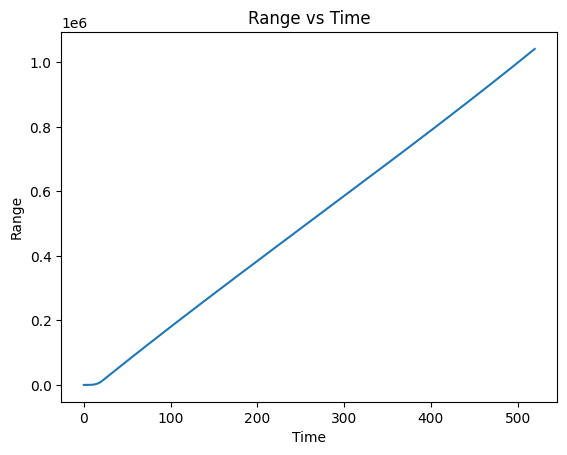

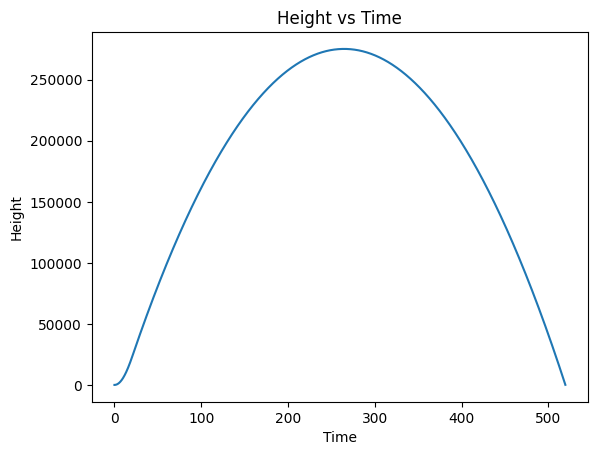

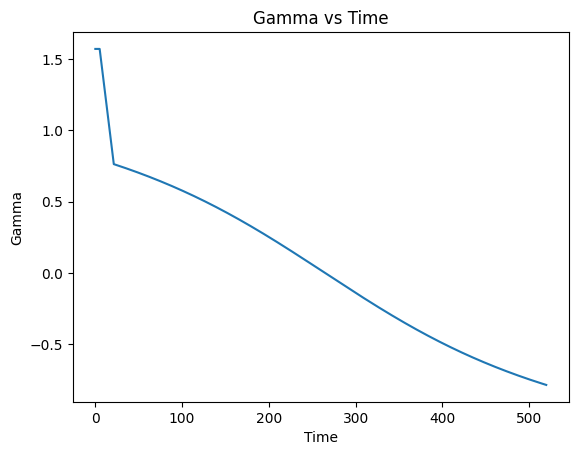

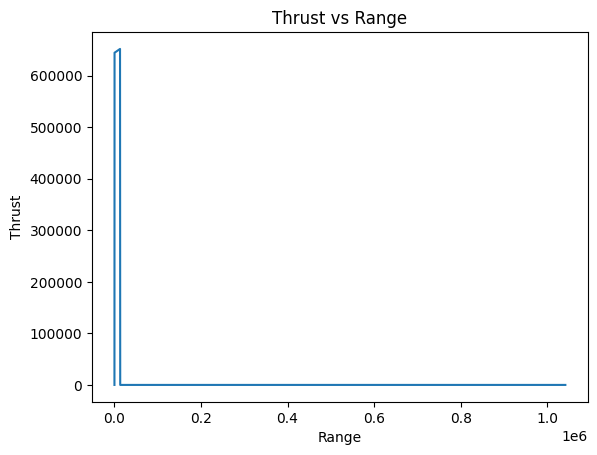

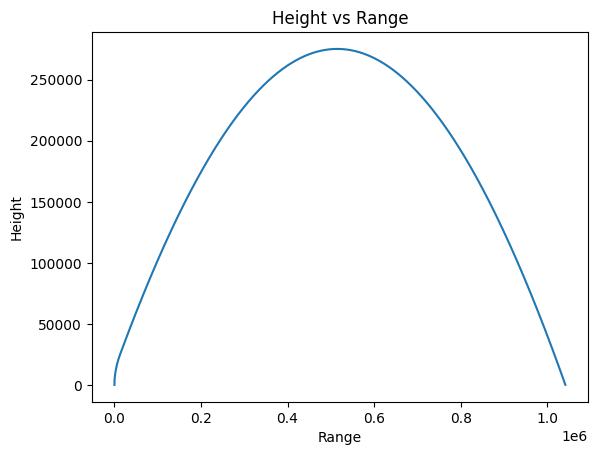

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 1668.2456349651272
Isp0: 698.7559937402699
drymass: 1648.8406887794074
thrust0: 56704.4350176575


Stage 1 burnout
Velocity (km/s):  3.529742657435766
Angle (deg h):  43.8126845362489
Range (km):  14.440881108664957
Time (sec):  20.600000000000026
Final results: 
Range (km):  1460.937863604253
Apogee (km):  389.3370146558854
Time to target (sec):  633.5000000000755




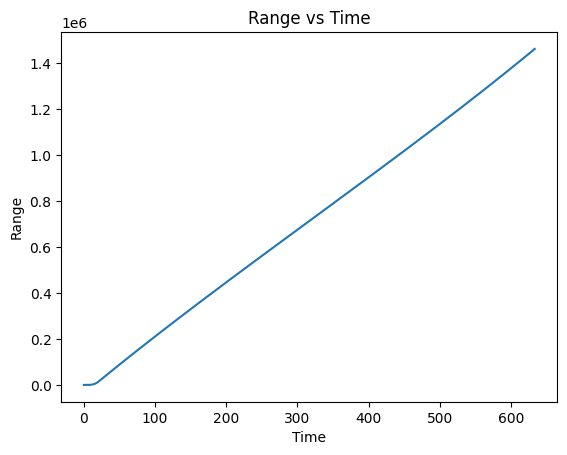

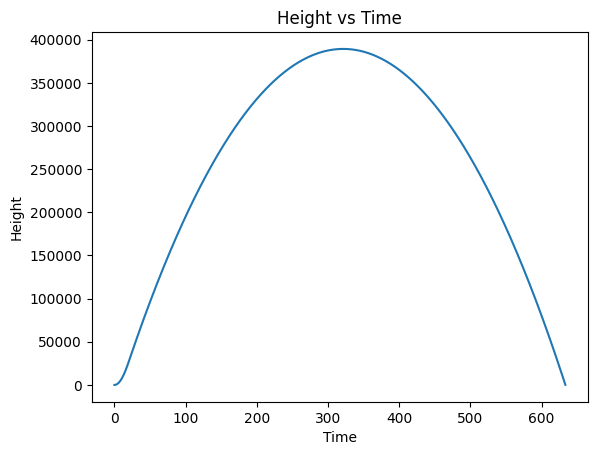

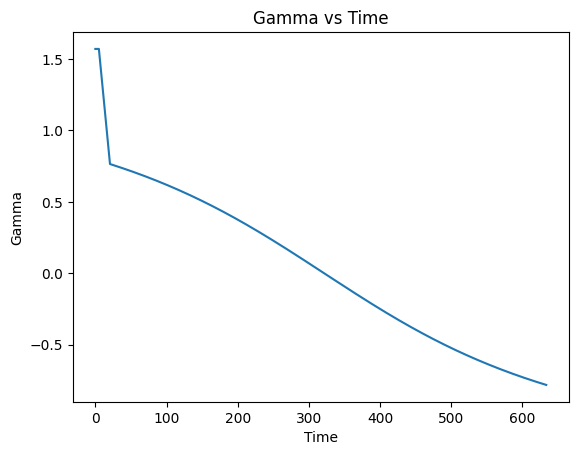

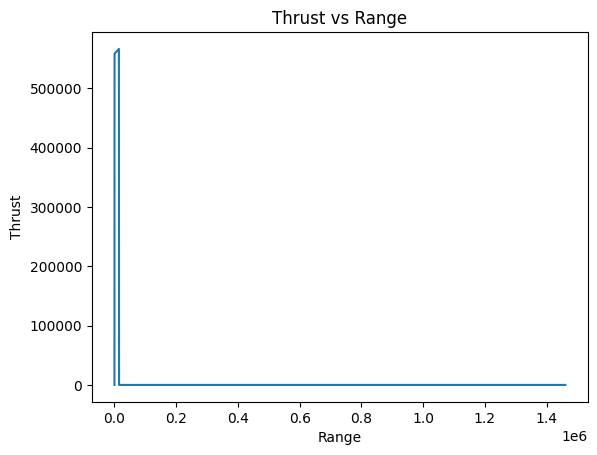

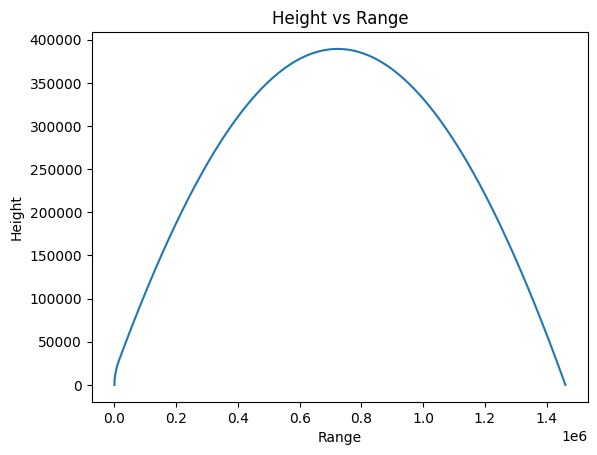

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 875.2898899473118
Isp0: 331.9824310097109
drymass: 1794.6179646068008
thrust0: 41189.869356908894


Stage 1 burnout
Velocity (km/s):  0.9391878492417518
Angle (deg h):  44.8411007129679
Range (km):  0.682935685381698
Time (sec):  7.099999999999992
Final results: 
Range (km):  94.3085399115824
Apogee (km):  25.64406596135342
Time to target (sec):  148.39999999999586




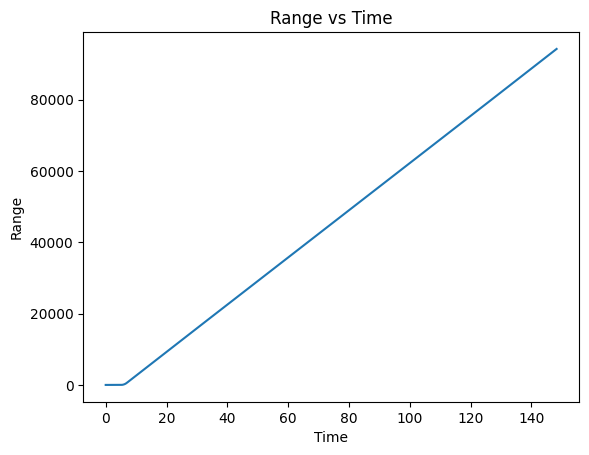

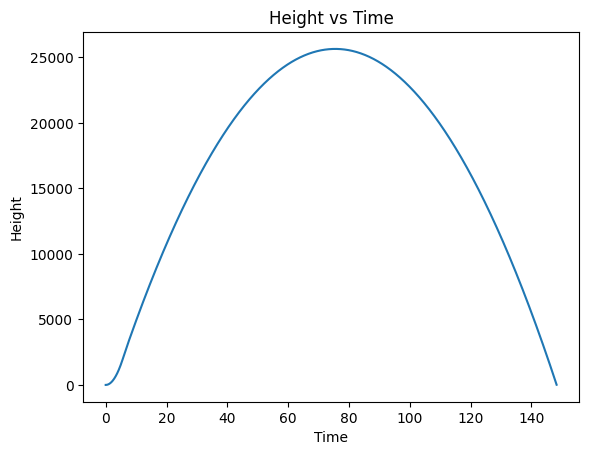

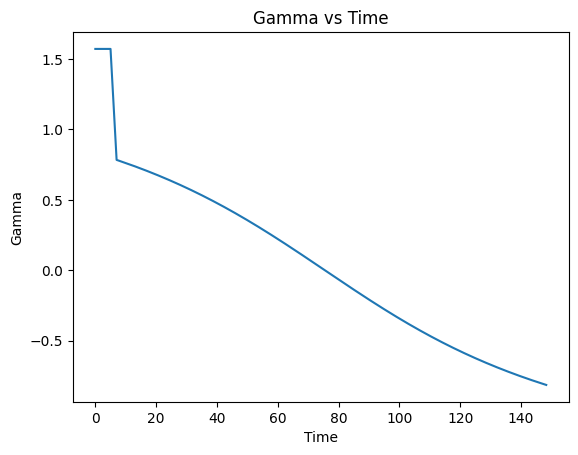

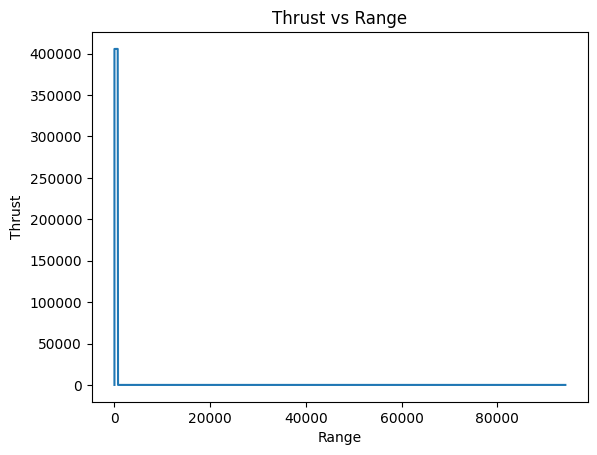

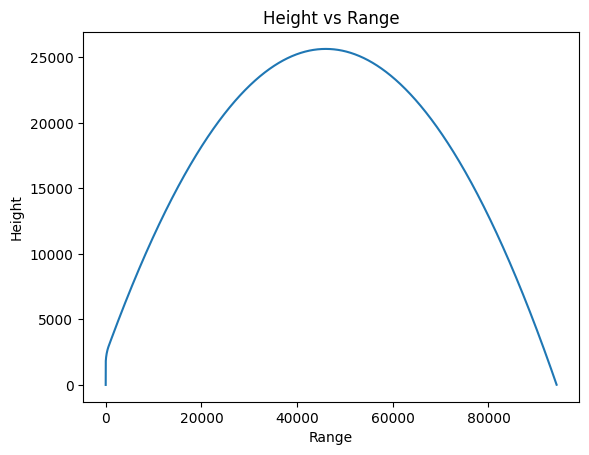

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 1624.2051736404383
Isp0: 653.9857127383873
drymass: 1561.2834340384566
thrust0: 53984.56333916678


Stage 1 burnout
Velocity (km/s):  3.3073582082906974
Angle (deg h):  43.88112559563039
Range (km):  12.848202588266286
Time (sec):  19.700000000000014
Final results: 
Range (km):  1266.540851486039
Apogee (km):  336.3865971247984
Time to target (sec):  581.5000000000637




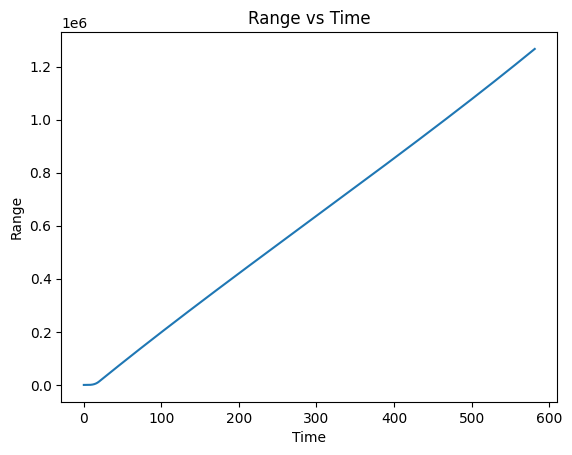

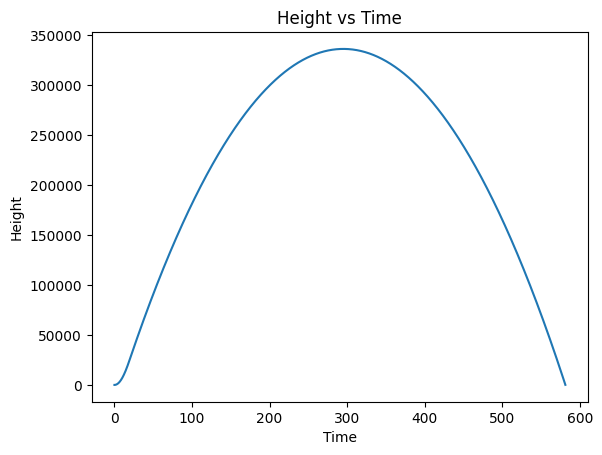

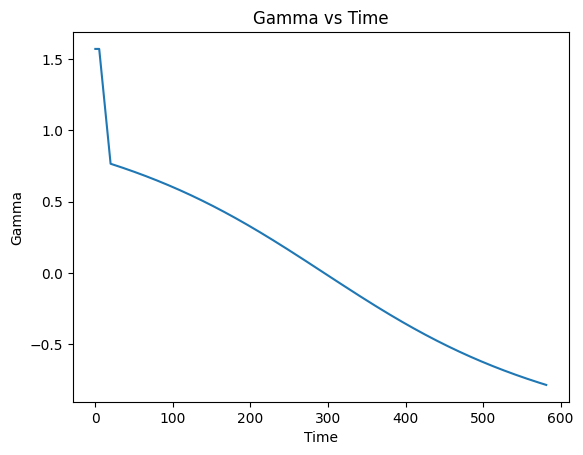

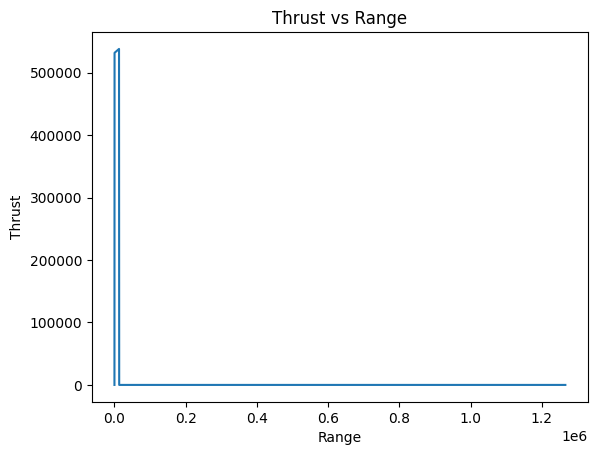

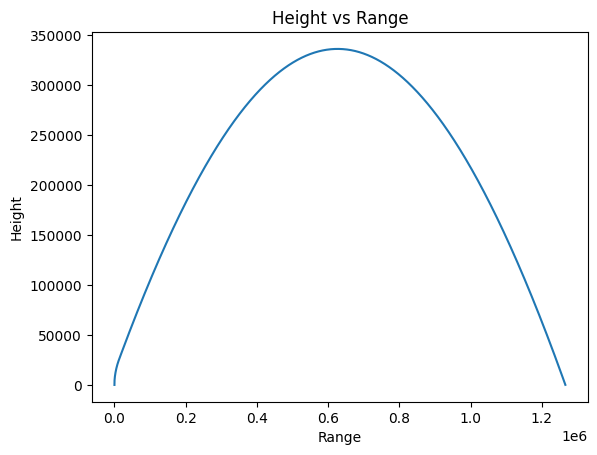

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 4074.9167915495586
Isp0: 655.5599321809301
drymass: 1336.3743307643394
thrust0: 15453.589071022314


Stage 1 burnout
Velocity (km/s):  6.862230435095325
Angle (deg h):  43.66706666437488
Range (km):  215.9339020571741
Time (sec):  172.89999999999446
Final results: 
Range (km):  8155.601736216443
Apogee (km):  3125.7358379938883
Time to target (sec):  2809.69999999854




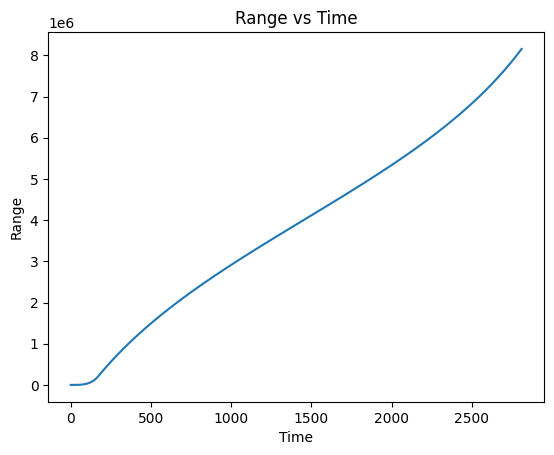

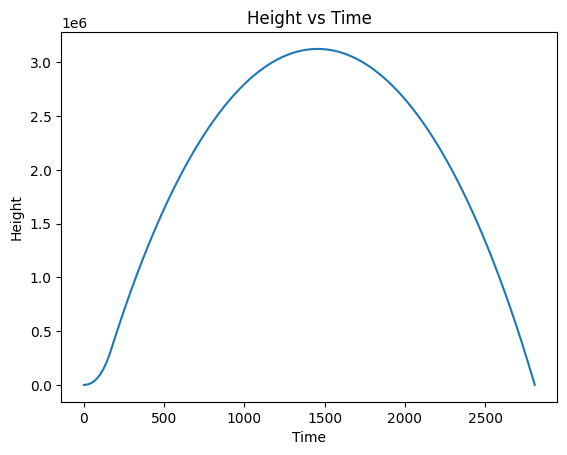

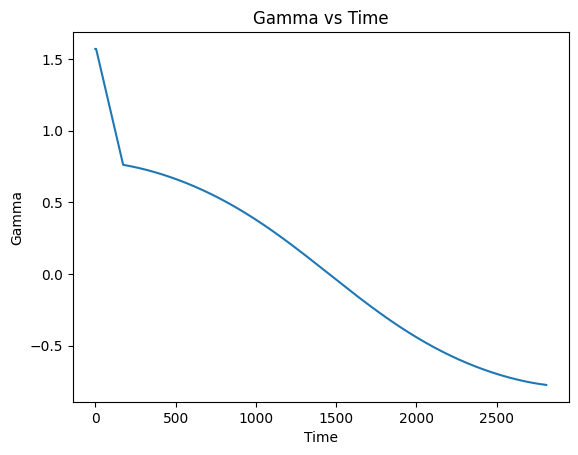

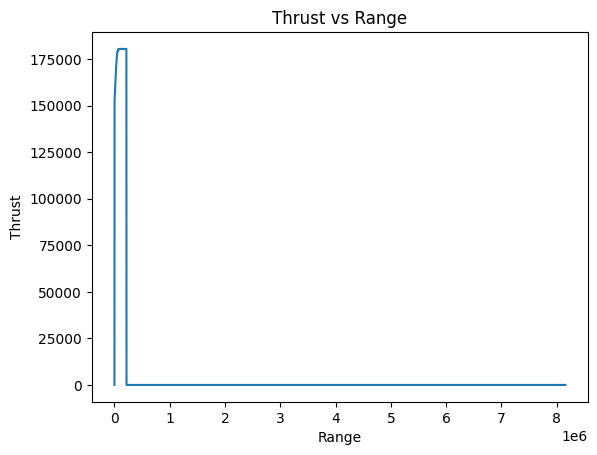

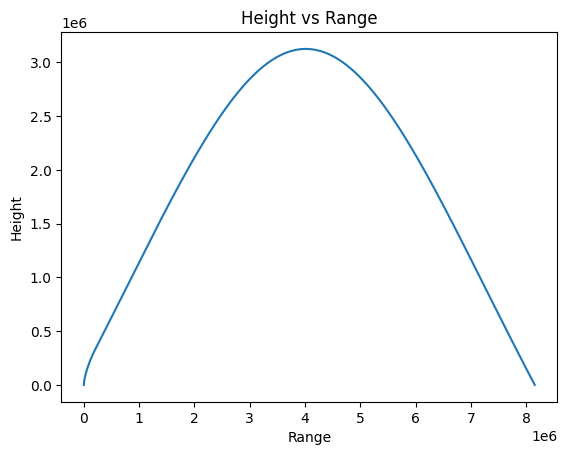

Data written to 'results/results_4.txt'

New simulation 

fuelmass: 5325.961511759926
Isp0: 233.8097705788021
drymass: 2117.9369387515953
thrust0: 34964.53341353082


Stage 1 burnout
Velocity (km/s):  2.1288990447488123
Angle (deg h):  43.67351408726213
Range (km):  14.637044050479412
Time (sec):  35.600000000000236
Final results: 
Range (km):  521.4484161819754
Apogee (km):  142.71438971857776
Time to target (sec):  373.7000000000165




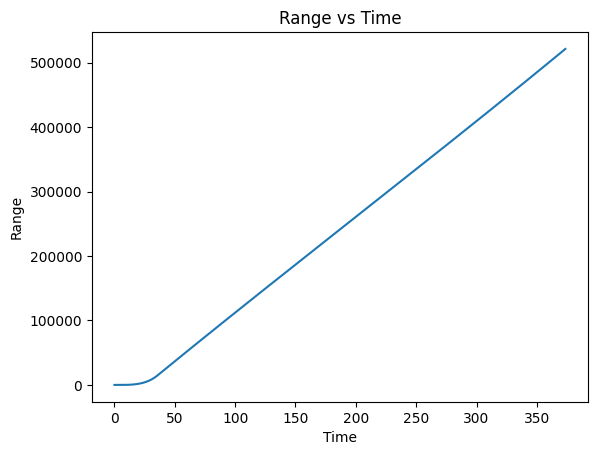

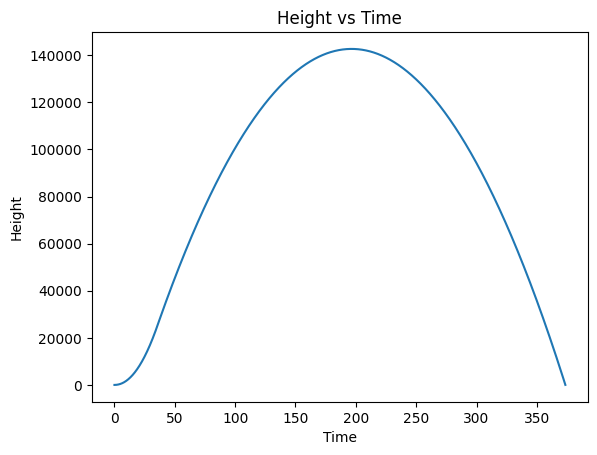

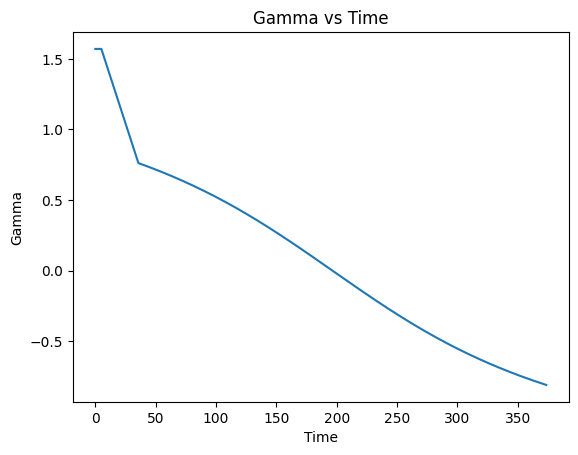

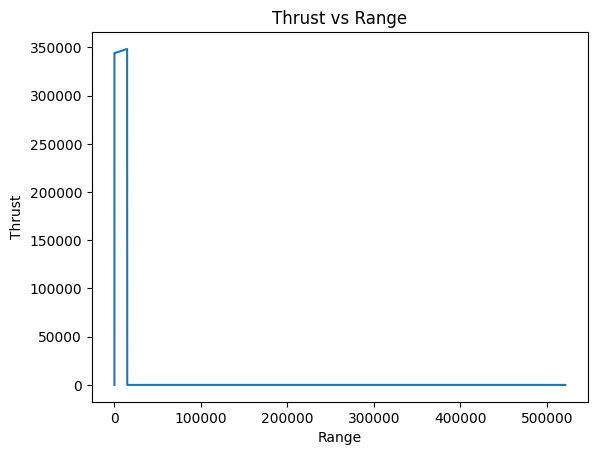

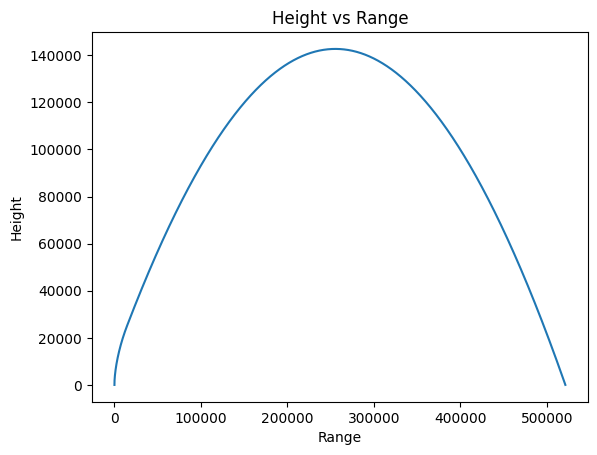

Data written to 'results/results_5.txt'

New simulation 

fuelmass: 2563.044626547295
Isp0: 573.2468613639558
drymass: 2869.20652887092
thrust0: 15061.146500020135


Stage 1 burnout
Velocity (km/s):  2.346355719728618
Angle (deg h):  43.66183978946334
Range (km):  47.76374452123826
Time (sec):  97.59999999999873
Final results: 
Range (km):  716.0939797895957
Apogee (km):  225.36965950100196
Time to target (sec):  506.50000000004667




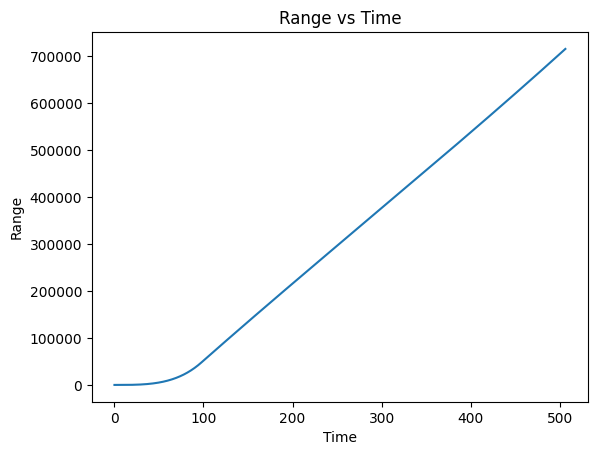

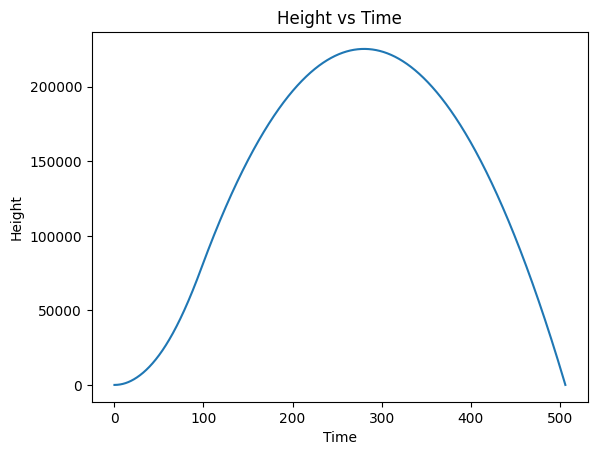

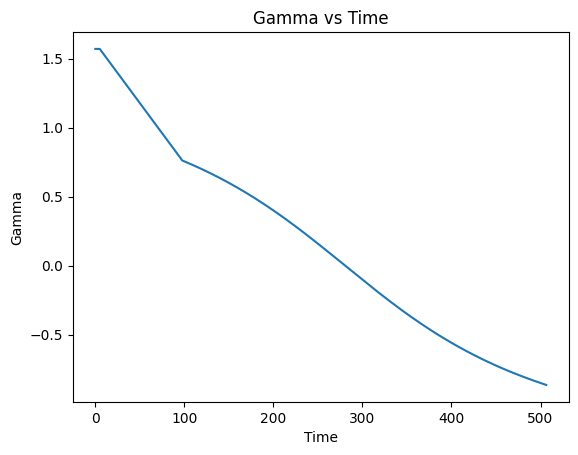

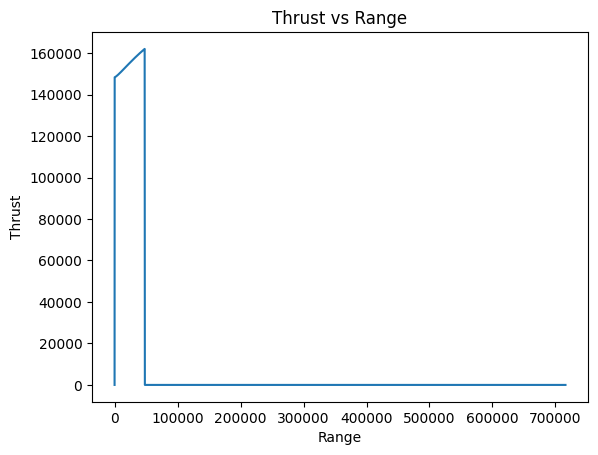

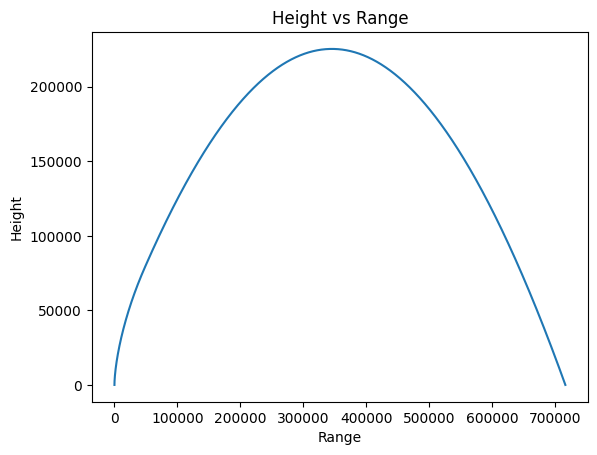

Data written to 'results/results_6.txt'

New simulation 

fuelmass: 1188.2097551931147
Isp0: 479.45148884085927
drymass: 2765.291173606306
thrust0: 16928.141974067268


Stage 1 burnout
Velocity (km/s):  1.0627600987936285
Angle (deg h):  43.69966590320874
Range (km):  7.914340960251068
Time (sec):  33.70000000000021
Final results: 
Range (km):  137.89216085764292
Apogee (km):  42.457085854950016
Time to target (sec):  204.0999999999927




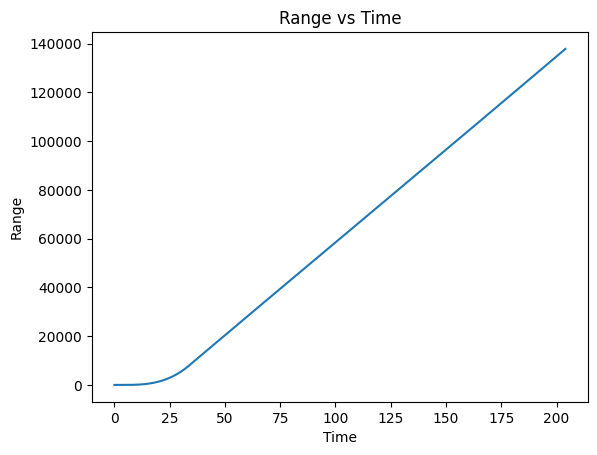

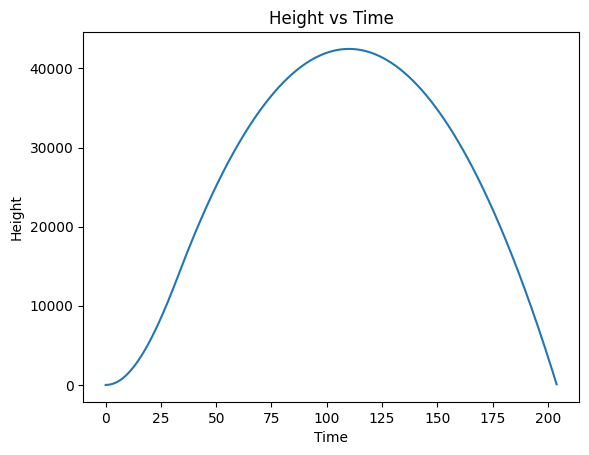

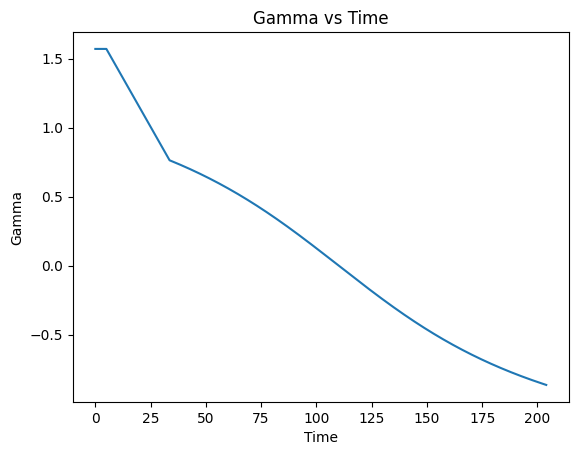

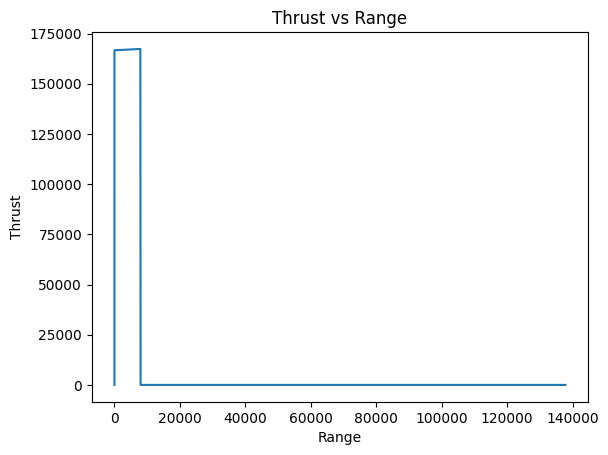

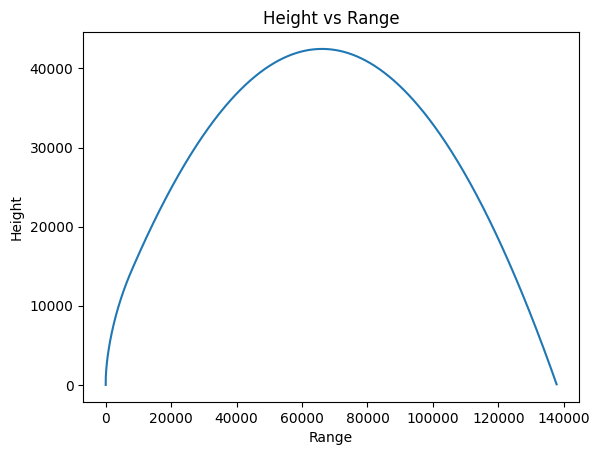

Data written to 'results/results_7.txt'

New simulation 

fuelmass: 2861.3421823975145
Isp0: 755.4940454324452
drymass: 2508.527032617174
thrust0: 36822.928226003394


Stage 1 burnout
Velocity (km/s):  4.52019200489899
Angle (deg h):  43.65598758532239
Range (km):  55.24424924567668
Time (sec):  58.700000000000564
Final results: 
Range (km):  2672.152259976377
Apogee (km):  769.9766174698592
Time to target (sec):  981.6000000001546




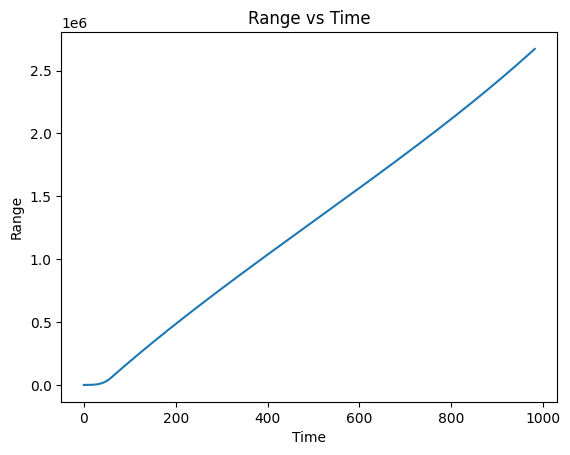

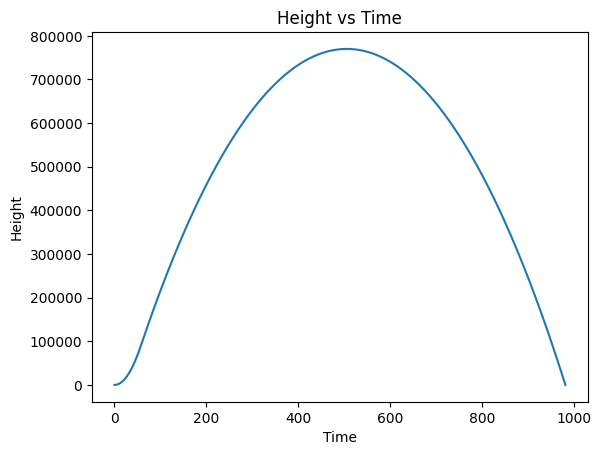

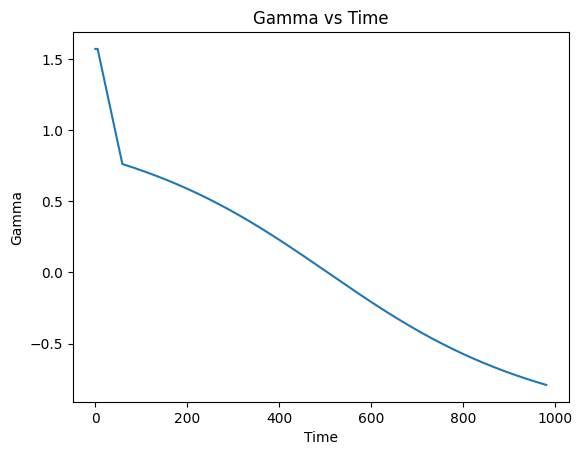

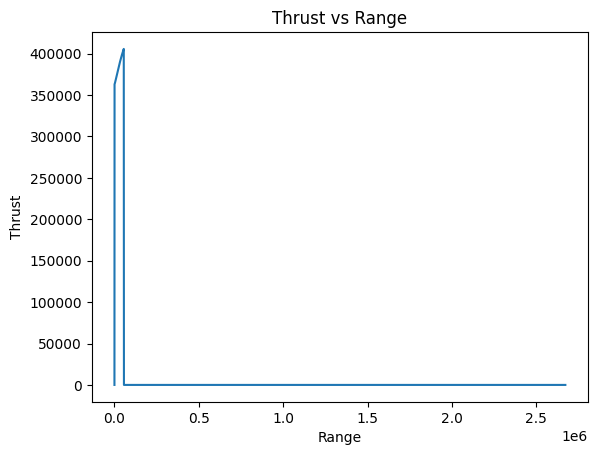

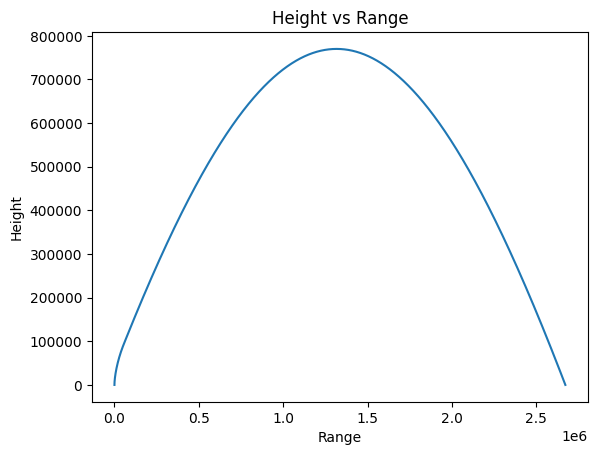

Data written to 'results/results_8.txt'

New simulation 

fuelmass: 1451.8082607137721
Isp0: 641.1024907769828
drymass: 2702.8548676884043
thrust0: 33713.420994605905


Stage 1 burnout
Velocity (km/s):  1.9693880933278234
Angle (deg h):  43.66707096084313
Range (km):  11.593783334798152
Time (sec):  27.600000000000126
Final results: 
Range (km):  442.9643985480602
Apogee (km):  121.35160126964614
Time to target (sec):  337.4000000000082




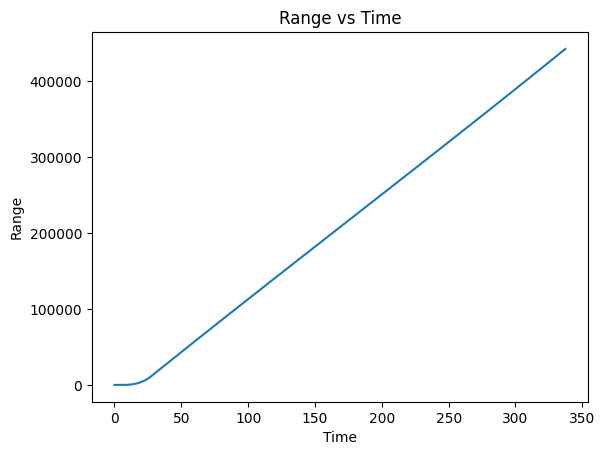

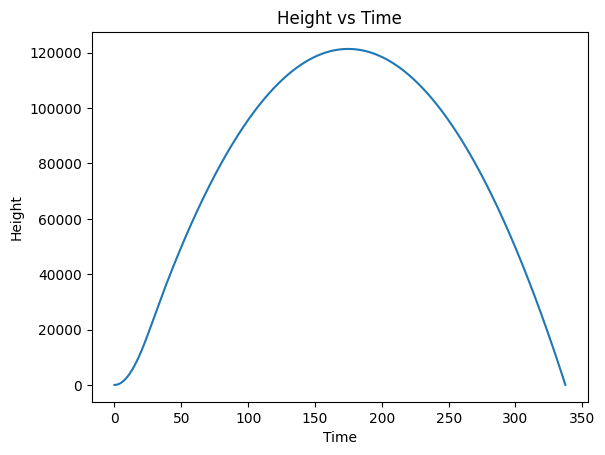

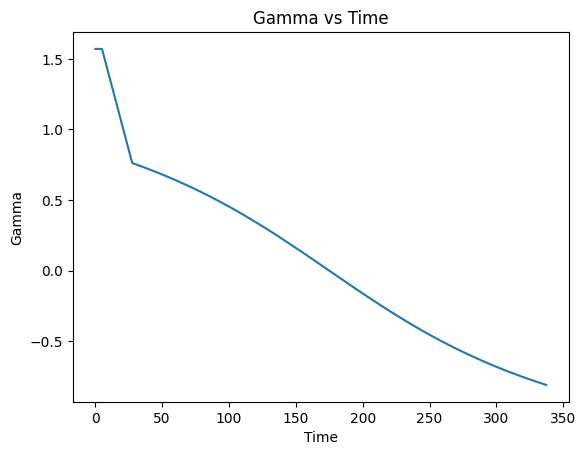

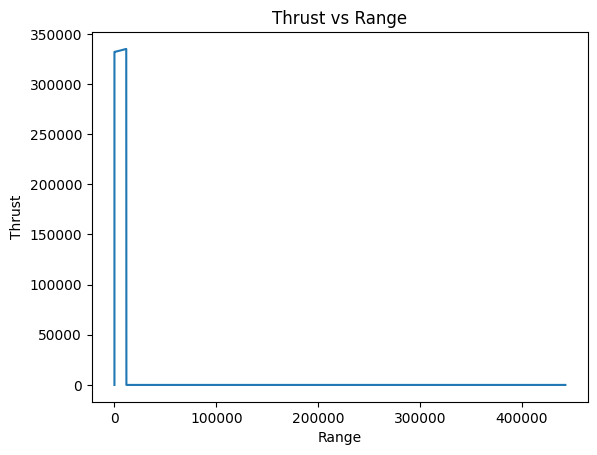

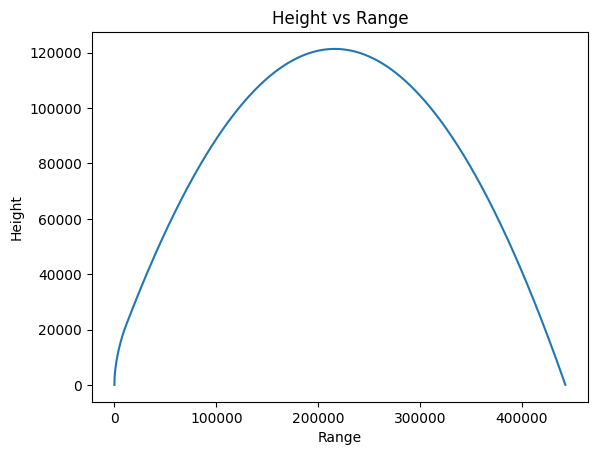

Data written to 'results/results_9.txt'

New simulation 

fuelmass: 5433.837824180632
Isp0: 767.5505588670873
drymass: 1968.2095331309777
thrust0: 57339.329776499166


Stage 1 burnout
Velocity (km/s):  8.900513299305782
Angle (deg h):  43.678079902372325
Range (km):  122.95757104974452
Time (sec):  72.80000000000014
Final results: 
Range (km):  14608.336359100906
Apogee (km):  10017.029094322772
Time to target (sec):  7928.0000000113105




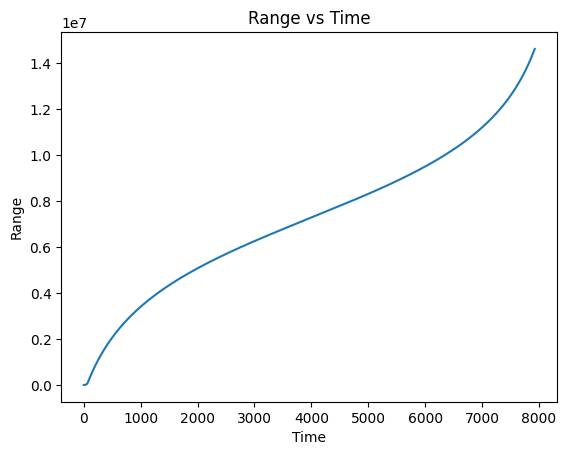

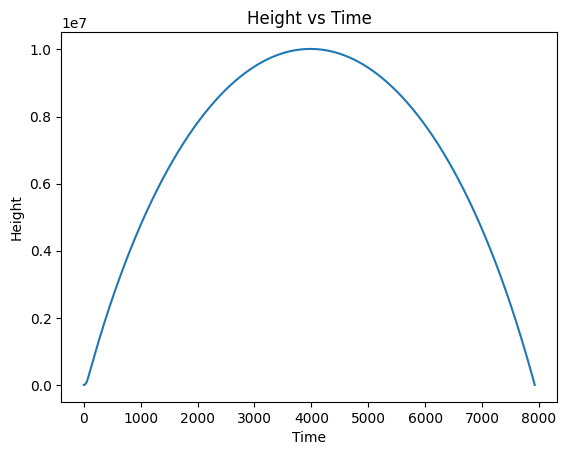

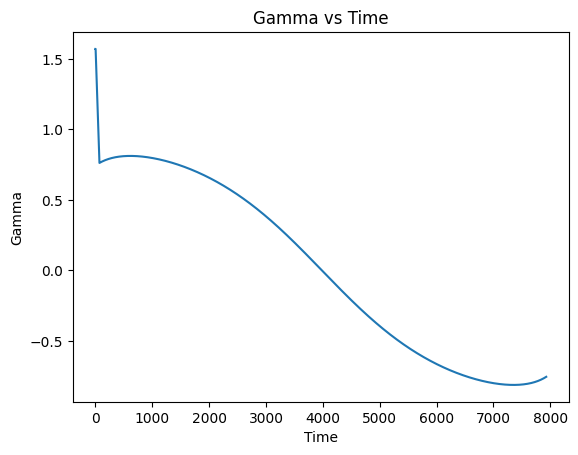

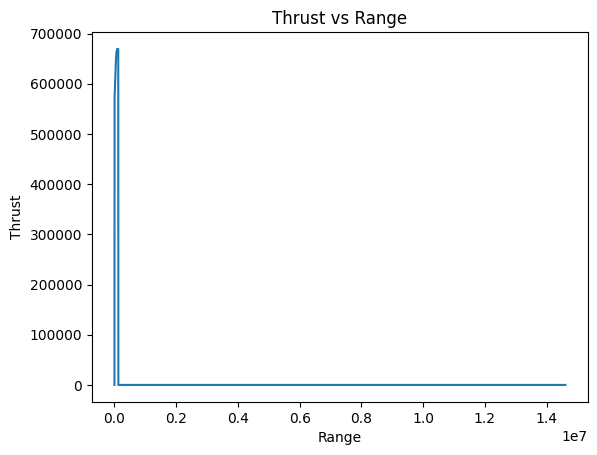

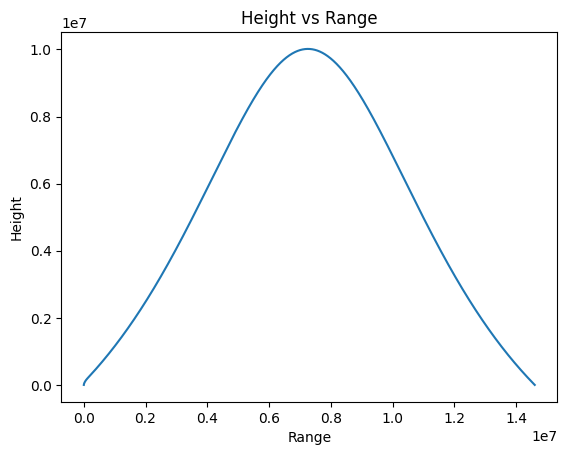

Data written to 'results/results_10.txt'

New simulation 

fuelmass: 4621.899660728851
Isp0: 762.1986332559965
drymass: 1076.7880473593643
thrust0: 43579.398824380914


Stage 1 burnout
Velocity (km/s):  10.585515745556776
Angle (deg h):  43.6761649575562
Range (km):  156.31098259975738
Time (sec):  80.89999999999968
Simulation exceeded time limit.
Final results: 
Range (km):  8513.45059578087
Apogee (km):  62785.36440110176
Time to target (sec):  20000.099999989452




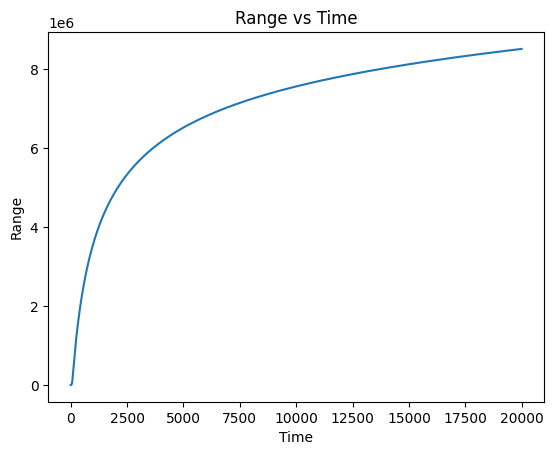

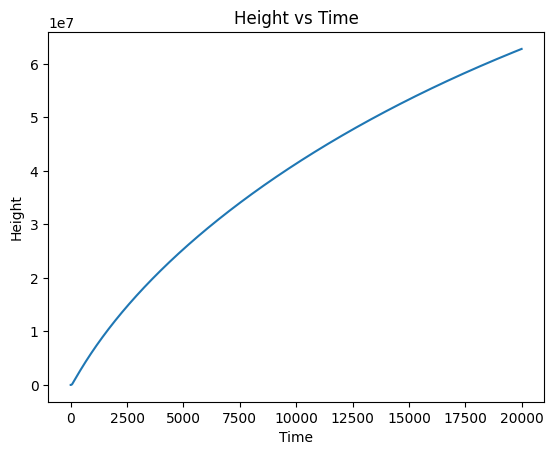

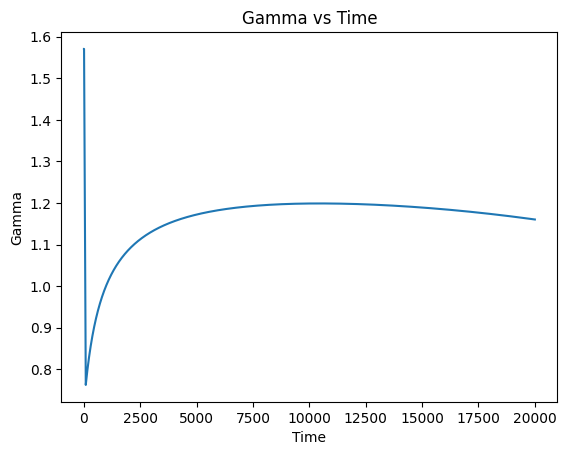

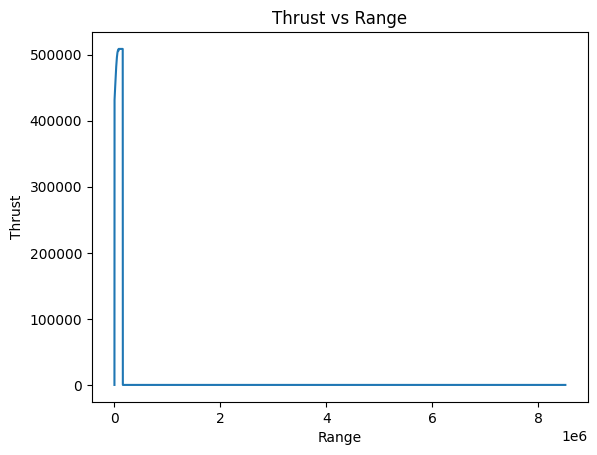

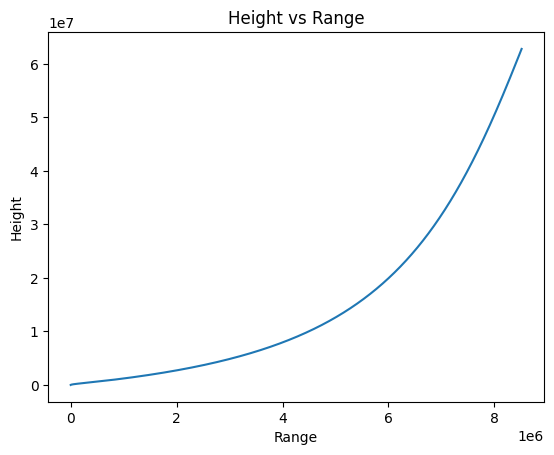

Data written to 'results/results_11.txt'


In [16]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m4_design = RandomDesign(m4_space)
m4_x = m4_design.get_samples(3*4)
m4_y = run_missile_sim(m4_x)



In [17]:
# Build model
m4_var_kernel = (100)**2 
m4_lengthscale = 100 # 1
m4_var_noise = 1e-5 # small value

constrain_lengthscale = True

m4_rbf_kern = GPy.kern.RBF(input_dim=nr_custom_params, lengthscale=m4_lengthscale)
if constrain_lengthscale:
    m4_rbf_kern.lengthscale.constrain_bounded(m4_lengthscale, m4_lengthscale*1e12)

m4_kern = m4_rbf_kern + \
    GPy.kern.Linear(input_dim=nr_custom_params)

m4_model_gpy = GPRegression(m4_x,m4_y, kernel=m4_kern)
m4_model_gpy.kern.variance =  m4_var_kernel 
m4_model_gpy.likelihood.variance.fix(m4_var_noise)  

display(m4_model_gpy)






reconstraining parameters rbf.lengthscale


GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,100.0,"100.0,100000000000000.0",
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [18]:
m4_model_emukit = GPyModelWrapper(m4_model_gpy)
m4_model_emukit.optimize()

display(m4_model_gpy)

GP_regression.,value,constraints,priors
sum.rbf.variance,14781920611.63005,+ve,
sum.rbf.lengthscale,100.0,"100.0,100000000000000.0",
sum.linear.variances,5.562684646268137e-309,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [19]:
if m4_evaluate:
    # Compute predictions through emulator
    m4_mu_plot_grid_pred, var_plot_grid_pred = m4_model_emukit.predict(m4_x_plot)

    m4_rmse = evaluate_prediction(y_actual=m4_y_plot, y_predicted=m4_mu_plot_grid_pred)
    print("RMSE m4 (pre experiment design loop): ", m4_rmse)

In [20]:
m4_2_model_emukit = m4_model_emukit

In [21]:
# Experimental design to improve emulator
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m4_space,
                                                  model=m4_2_model_emukit)
m4_ed = ExperimentalDesignLoop(space=m4_space, 
                            model=m4_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m4_ed.run_loop(user_function=run_missile_sim, stopping_condition=5*4)



NameError: name 'IntegratedVarianceReduction' is not defined

In [ ]:
wirte_output_txt = False

if m4_evaluate:
    # Compute predictions through emulator
    m4_mu_plot_grid_pred2, var_plot_grid_pred = m4_2_model_emukit.predict(m4_x_plot)

    m4_2_rmse = evaluate_prediction(y_actual=m4_y_plot, y_predicted=m4_mu_plot_grid_pred2)
    print("RMSE m4 (post experiment design loop): ", m4_2_rmse)
    

#### Run sensitivity

In [ ]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model = m4_2_model_emukit, input_domain = m4_space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [ ]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [ ]:
import pandas as pd


In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='first-order-sobol-indices-gp-missile.svg', directory='./uq')


In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='total-effects-sobol-indices-gp-missile.svg', directory='./uq')